In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.nn.init import kaiming_uniform_
from torch.distributions import Normal
from scipy.ndimage.filters import uniform_filter1d
from matplotlib import pyplot as plt

In [2]:
import numpy as np
import gym
from tqdm import tqdm
import random as rand
from itertools import count
import time
import gym

In [3]:
class ReplayMemory():
    def __init__(self,capacity):   
        self.capacity = capacity
        self.memory = []
        self.push_count = 0
        
    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count%self.capacity] = experience
        self.push_count+=1
    
    def sample(self, batch_size):
        return rand.sample(self.memory,batch_size)
    
    def can_provide_sample(self, batch_size):
        return len(self.memory)>=batch_size
    
    def update_td_error(self, sampled_experiences):
        for sampled_idx,sampled_exp in enumerate(sampled_experiences):
            for mem_idx, mem_exp in enumerate(self.memory):
                if mem_exp.timestep == sampled_exp.timestep:
                    self.memory[mem_idx] = sampled_exp #update memory
                    break
        
    def get_memory_values(self):
        return self.memory 

In [4]:
def extract_tensors(experiences):
    batch = Xp(*zip(*experiences))
    state = np.stack(batch.state) #stack
    action = np.stack(batch.action)
    next_state = np.stack(batch.next_state)
    reward = np.stack(batch.reward)
    done = np.stack(batch.done)
    abs_td_error = np.stack(batch.abs_td_error)
    timestep = np.stack(batch.timestep)
    return state,action,next_state,reward,done,abs_td_error,timestep

In [5]:
def rebuild_experiences(state, action, next_state, reward, done, abs_error, timestep):
    exp_list = []
    for idx_ in range(len(state)):
        exp_list.append(\
                        Xp(state[idx_], action[idx_], next_state[idx_], reward[idx_],\
                           done[idx_], abs_error[idx_], timestep[idx_]))
    return exp_list

In [6]:
from collections import namedtuple
Xp = namedtuple('Experience',
                        ('state', 'action', 'next_state', 'reward', 'done', 'abs_td_error','timestep'))
Xp_points = Xp(5,6,7,8,9,10,11)
Xp_points

Experience(state=5, action=6, next_state=7, reward=8, done=9, abs_td_error=10, timestep=11)

In [7]:
class FCGP(nn.Module):
    def __init__(self,env, observation_space, action_space, hidden_dims=(32,32),\
                log_alpha_lr=0.001, min_log= -20, max_log=2):
        super(FCGP, self).__init__()
        self.input_size = observation_space
        self.env = env
        self.distribution_out = action_space
        self.mean_out = action_space
        self.log_alpha_lr = log_alpha_lr
        self.min_log = min_log
        self.max_log = max_log
        self.input_layer = nn.Linear(self.input_size, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims) - 1):
            hidden_layer = nn.Linear(hidden_dims[i],\
                                    hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
        
        self.mean_layer = nn.Linear(hidden_dims[-1], action_space)#predict mean
        self.distribution_layer = nn.Linear(hidden_dims[-1], action_space)#predict distribution
        
        self.target_entropy =  -1 * torch.tensor(np.prod(env.action_space.high.shape)).float()#recommended target entropy
        self.log_alpha = torch.zeros(1, requires_grad=True)
        self.target_entropy_optimizer = torch.optim.Adam([self.log_alpha],\
                                                         lr=log_alpha_lr)
        self.device = torch.device("cuda" if torch.cuda.is_available()\
                                  else "cpu")
        self.to(self.device)
        
    def forward(self, state):
        if not isinstance(state, torch.Tensor):
            state = torch.tensor(state).float().to(self.device)
        x = F.relu(self.input_layer(state))
        for hidden_layer in self.hidden_layers:
            x = F.relu(hidden_layer(x))
        mean_output = self.mean_layer(x)
        log_distribution_output = self.distribution_layer(x)
        log_distribution_output = log_distribution_output.clamp(self.min_log, self.max_log)#clamp log values so that they wont explode
        return mean_output, log_distribution_output
    
    def rescale_actions(self, x):
        tan_min = torch.tanh(torch.Tensor([float('-inf')])).to(self.device)
        tan_max = torch.tanh(torch.Tensor([float('inf')])).to(self.device)
        env_high = torch.tensor(self.env.action_space.high).float().to(self.device)
        env_low = torch.tensor(self.env.action_space.low).float().to(self.device)
        rescale_fn = lambda x: (x - tan_min) * (env_high - env_low)/\
                                     (tan_max - tan_min) + env_low
        x = rescale_fn(x)
        return x.to(self.device)
        
    
    def full_pass(self, state, epsilon=1e-6):
        if not isinstance(state, torch.Tensor):
            state = torch.tensor(state).float().to(self.device)
        mean, log_distribution = self.forward(state)
        pi_s = Normal(mean, log_distribution.exp())
        sampled_distributions = pi_s.rsample()
        tan_h_actions = torch.tanh(sampled_distributions)
        
        rescaled_actions = self.rescale_actions(tan_h_actions)
        log_probs = pi_s.log_prob(sampled_distributions) - torch.log((\
                                                            1 - tan_h_actions.pow(2)).clamp(0,1) + epsilon)
        log_probs = log_probs.sum(dim=1, keepdim=True)
        return rescaled_actions, mean, log_probs

In [8]:
class FCQV(nn.Module):
    def __init__(self, observation_space, action_space, hidden_dims=(32,32)):
        super(FCQV, self).__init__()
        self.input_size = observation_space
        self.action_space = action_space
        self.input_layer = nn.Linear(self.input_size + self.action_space,\
                                    hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
        self.output_layer = nn.Linear(hidden_dims[-1], 1)
        self.device = torch.device("cuda" if torch.cuda.is_available()\
                                  else "cpu")
        self.to(self.device)
        
    def forward(self, state, action):
        if not isinstance(state, torch.Tensor):
            state = torch.tensor(state).float().to(self.device)
        if not isinstance(action, torch.Tensor):
            action = torch.tensor(action).float().to(self.device)
        x = torch.cat((state, action), dim=1)
        x = F.relu(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = F.relu(hidden_layer(x))
        x = self.output_layer(x) 
        return x

In [9]:
def prioritize_samples(experience_samples, alpha, beta):
    state,action,next_state,reward,done,abs_td_error,timesteps \
                            = extract_tensors(experience_samples)
    abs_td_error, indices_ = (list(t) for t in zip(*sorted(\
                            zip(abs_td_error.tolist(), timesteps))))
    abs_td_error.reverse()
    indices_.reverse()#reverse to march sort func
    abs_td_error = np.array(abs_td_error)
    abs_td_error  = torch.tensor(abs_td_error)
    ranks = np.arange(1, len(abs_td_error)+1)
    priorities = 1.0/ranks
    priorities = priorities**alpha
    priorities = np.expand_dims(priorities, axis=1)
    probabilities = priorities/np.sum(priorities, axis=0)
    assert np.isclose(probabilities.sum(), 1.0)
    number_of_samples  = len(probabilities)
    weight_importance_ = number_of_samples*probabilities
    weight_importance_ = weight_importance_**-beta
    weight_importance_max = np.max(weight_importance_)
    weight_importance_scaled = weight_importance_/weight_importance_max
    return weight_importance_scaled, indices_ 

In [10]:
def update_model(experience_samples,\
                online_policy_network, online_policy_optimizer,\
                online_q_network_a, online_qa_network_optimizer,\
                online_q_network_b, online_qb_network_optimizer,\
                target_q_network_a, target_q_network_b,\
                gamma, weighted_importance, timestep_indices,\
                current_t_step, update_online_policy):
    states, actions, next_states, rewards, done, _ , timesteps =\
                extract_tensors(experience_samples)
    device = torch.device("cuda" if torch.cuda.is_available()\
                        else "cpu") 
    arrange_weighted_values = [timestep_indices.index(i) for i in timesteps]
    
    states = torch.tensor(np.squeeze(states)).float().to(device)
    next_states = torch.tensor(np.squeeze(next_states)).float().to(device)
    actions = torch.tensor(actions).float().to(device)
    rewards = torch.tensor(rewards).unsqueeze(1).float().to(device)
    done = torch.tensor(done).unsqueeze(1).float().to(device)
    weighted_importance = torch.tensor(weighted_importance).float().to(device)
    
    #optimize alpha
    current_actions,_, log_pi_s = online_policy_network.full_pass(states)
    target_alpha = (online_policy_network.target_entropy +\
                   log_pi_s).detach()
    alpha_loss = -(online_policy_network.log_alpha*\
                 target_alpha).mean()
    online_policy_network.target_entropy_optimizer.zero_grad()
    alpha_loss.backward()
    online_policy_network.target_entropy_optimizer.step()
    
    #set alpha
    alpha = online_policy_network.log_alpha.exp()
    
    #optimize online using target nets
    predicted_action_policy,_, log_pi_ns =\
                                    online_policy_network.full_pass(next_states)

    qsa_target_a = target_q_network_a(next_states, predicted_action_policy)
    qsa_target_b = target_q_network_b(next_states, predicted_action_policy)
    target_qsa = torch.min(qsa_target_a, qsa_target_b)
    target_qsa = target_qsa - alpha*log_pi_ns
    target_qsa = rewards + gamma*target_qsa*(1 - done)
    target_qsa = target_qsa*weighted_importance
    target_qsa = target_qsa.detach()
    
    qsa_online_a = online_q_network_a(states, actions)
    qsa_online_b = online_q_network_b(states, actions)
    qsa_online_a = qsa_online_a*weighted_importance.detach()
    qsa_online_b = qsa_online_b*weighted_importance.detach()
    
    
    #update online networks
    loss_func = torch.nn.SmoothL1Loss()
    qa_loss = loss_func(qsa_online_a, target_qsa.detach())
    qb_loss = loss_func(qsa_online_b, target_qsa.detach())
    
    online_qa_network_optimizer.zero_grad()
    qa_loss.backward()
    online_qa_network_optimizer.step()
    
    online_qb_network_optimizer.zero_grad()
    qb_loss.backward()
    online_qb_network_optimizer.step()
    
    
    abs_a = (target_qsa - qsa_online_a)
    abs_b = (target_qsa - qsa_online_b)
    ovr_update = (abs_a + abs_b)/2
    ovr_update = np.absolute(ovr_update.detach().cpu().numpy())
    

    
    if current_t_step%update_online_policy == 0:
        current_actions,_ , log_pi = online_policy_network.full_pass(states)
        qsa_online_a = online_q_network_a(states, current_actions)
        qsa_online_b = online_q_network_b(states, current_actions)
        qsa_min = torch.min(qsa_online_a, qsa_online_b)
        policy_loss = (alpha.detach()*log_pi\
                      -qsa_min.detach()).mean()
        online_policy_optimizer.zero_grad()
        policy_loss.backward()
        online_policy_optimizer.step()
    states, actions, next_states, rewards, done, td_err , timesteps =\
                extract_tensors(experience_samples)    
    experiences_rebuilded = rebuild_experiences\
                    (states, actions, next_states, rewards, done, ovr_update, timesteps)
    return experiences_rebuilded,online_policy_network

In [11]:
def query_error(online_policy_network, offline_q_network_a, offline_q_network_b,\
                online_q_network_a, online_q_network_b, state, action, next_state, reward, gamma):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    state = torch.tensor(state).unsqueeze(0).float().to(device)
    next_state = torch.tensor(next_state).unsqueeze(0).float().to(device)
    alpha = online_policy_network.log_alpha.exp()
    ns_actions,_, log_pi_ns = online_policy_network.full_pass(next_state)
    q_target_next_states_action_a = offline_q_network_a(next_state,\
                                                    ns_actions.detach())
    q_target_next_states_action_b = offline_q_network_b(next_state,\
                                                    ns_actions.detach())
    q_min = torch.min(q_target_next_states_action_a, q_target_next_states_action_b)
    q_target = q_min - alpha * log_pi_ns
    q_target = reward + (gamma*q_target.detach())
    action = np.expand_dims(action, axis=0)
    q_online_state_action_val_a = online_q_network_a(state, action)
    q_online_state_action_val_b = online_q_network_b(state, action)
    abs_a = (q_target - q_online_state_action_val_a)
    abs_b = (q_target - q_online_state_action_val_b)
    abs_stack = (abs_a + abs_b)/2
    ovr_abs_update = abs_stack
    return np.absolute(ovr_abs_update.detach().cpu().numpy())

In [12]:
def rescale_actions(x, env):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tan_min = torch.tanh(torch.Tensor([float('-inf')])).to(device)
    tan_max = torch.tanh(torch.Tensor([float('inf')])).to(device)
    env_high = torch.tensor(env.action_space.high).float().to(device)
    env_low = torch.tensor(env.action_space.low).float().to(device)
    rescale_fn = lambda x: (x - tan_min) * (env_high - env_low)/\
                                     (tan_max - tan_min) + env_low
    x = rescale_fn(x)
    return x

In [13]:
def select_action(state, online_policy_network, env, warm_up, batch_size, memory):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    state = torch.tensor(state).float().to(device)
    state = state.unsqueeze(0)
    warm_up_action = batch_size * warm_up
    if memory.can_provide_sample(warm_up_action) == False:
        action = np.random.uniform(low=env.action_space.low, high=env.action_space.high)
        action = action.reshape(env.action_space.high.shape)
    else:
        with torch.no_grad():
            mean,log_std = online_policy_network.forward(state)
            action = torch.tanh(Normal(mean, log_std.exp()).sample())
            action = rescale_actions(action, env)
            action = action.detach().cpu().numpy().reshape(env.action_space.high.shape)
    return action

In [14]:
def plot_grad_flow(named_parameters):
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean().detach().cpu().numpy())
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)

In [15]:
def copy_network(online_network, target_network):
    for online_weights, target_weights in zip(online_network.parameters(),\
                                              target_network.parameters()):
        target_weights.data.copy_(online_weights.data)
    return target_network

In [16]:
def update_networks(online_q_network_a, online_q_network_b,\
                    offline_q_network_a, offline_q_network_b, tau):
        
    for target_weights, online_weights in zip(offline_q_network_a.parameters(), online_q_network_a.parameters()):
        target_weight_update = (1.0 - tau)*target_weights.data
        online_weight_update = tau*online_weights.data
        sum_up = target_weight_update + online_weight_update
        target_weights.data.copy_(sum_up)
        
    for target_weights, online_weights in zip(offline_q_network_b.parameters(), online_q_network_b.parameters()):
        target_weight_update = (1.0 - tau)*target_weights.data
        online_weight_update = tau*online_weights.data
        sum_up = target_weight_update + online_weight_update
        target_weights.data.copy_(sum_up)

    return offline_q_network_a, offline_q_network_b

In [51]:
def SAC_PER(env,
         gamma=0.99,
         alpha_pr=0.4,
         beta_pr=0.3,
         memory_size = 5000,
         tau = 0.001,
         n_ep=120,
         max_steps = 100000,
         max_steps_per_ep = 300,
         warm_up=2,
         min_sample_size=500,
         batch_size = 64,
         offline_update = 500,
         policy_update=50,
         ):
    
    
    observation_space = len(env.reset())
    action_space_high, action_space_low = env.action_space.high, env.action_space.low
    n_actions = len(action_space_high)
    online_policy_network = FCGP(env,observation_space,n_actions,\
                                     hidden_dims=(128,64))
    
    online_q_network_a = FCQV(observation_space,\
                                     n_actions,hidden_dims=(128,64))
    online_q_network_b = FCQV(observation_space,\
                                     n_actions,hidden_dims=(128,64))
    
    target_q_network_a = FCQV(observation_space,\
                                     n_actions,hidden_dims=(128,64))
    target_q_network_b = FCQV(observation_space,\
                                     n_actions,hidden_dims=(128,64))
    
    #copy parameters from online to target
    target_q_network_a = copy_network(online_q_network_a, target_q_network_a)
    target_q_network_b = copy_network(online_q_network_b, target_q_network_b)
    
    target_q_network_a.eval()
    target_q_network_b.eval()
    
    online_policy_optimizer = torch.optim.Adam(online_policy_network.parameters(),lr=0.0008)
    online_qa_network_optimizer = torch.optim.Adam(online_q_network_a.parameters(),lr=0.0008)
    online_qb_network_optimizer = torch.optim.Adam(online_q_network_b.parameters(),lr=0.0008)
    
    memory = ReplayMemory(memory_size)
    
    t_step = 0 #important
    reward_per_ep = []
    
    
    for e in tqdm(range(n_ep)):
        state = env.reset()
        reward_accumulated = 0
        
        while True:
            env.render()
            action = select_action(state, online_policy_network, env, warm_up, batch_size, memory)
            #if memory.can_provide_sample(min_sample_size):
                #print(action)
            next_state, reward, done, info = env.step(action)
            td_error = query_error(online_policy_network, target_q_network_a, target_q_network_b,\
                                online_q_network_a, online_q_network_b,\
                                state, action, next_state, reward, gamma)
            td_error = np.squeeze(td_error, axis = 0)
            reward_accumulated+=reward
            is_truncated = 'TimeLimit.truncated' in info and\
                                info['TimeLimit.truncated']
            is_failure = done and not is_truncated
            memory.push(Xp(state, action, next_state, reward, is_failure, td_error, t_step))
            state = next_state
            t_step+=1
            if memory.can_provide_sample(min_sample_size):
                experience_samples = memory.sample(batch_size)
                weighted_importance, indices = prioritize_samples(experience_samples, alpha_pr, beta_pr)
                rebuilded_exp, online_policy_network = \
                    update_model(experience_samples,\
                                online_policy_network, online_policy_optimizer,\
                                online_q_network_a, online_qa_network_optimizer,\
                                online_q_network_b, online_qb_network_optimizer,\
                                target_q_network_a, target_q_network_b,\
                                gamma, weighted_importance, indices,\
                                t_step, policy_update)
                memory.update_td_error(rebuilded_exp)
                
            if t_step%offline_update == 0:
                offline_q_network_a, offline_q_network_b = update_networks(online_q_network_a, online_q_network_b,\
                                                                    target_q_network_a, target_q_network_b, tau)
            if done == True:
                reward_per_ep.append(reward_accumulated)
                break
            #if t_step % max_steps_per_ep == 0:
                #plot_grad_flow(online_policy_network.named_parameters())
                #break
            if t_step > max_steps:
                env.close()
                return reward_per_ep
    env.close()           
    return online_policy_network,reward_per_ep

In [52]:
env = gym.make("Pendulum-v1")#baseline env

In [53]:
env.close()

In [ ]:
pn, rewards = SAC_PER(env)

 63%|███████████████████████████████████████████████████▎                             | 76/120 [08:34<05:31,  7.53s/it]

In [ ]:
plot_grad_flow(pn.named_parameters())

In [ ]:
arr = uniform_filter1d(rewards, size=1)

In [ ]:
x = []
y = []
for i,e in enumerate(arr):
    y.append(i)
    x.append(e)

In [ ]:
plt.plot(y, x)#u=500, T=0.001 pu:50

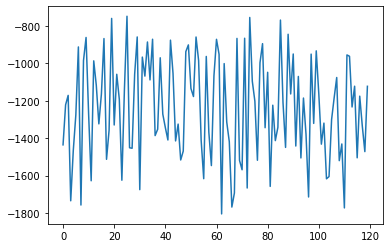

In [50]:
plt.plot(y, x)#u=500, T=0.001

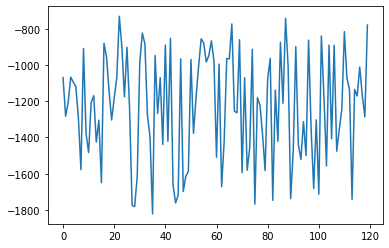

In [40]:
plt.plot(y, x)#u=500

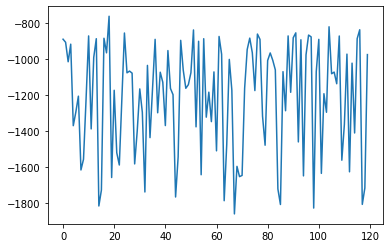

In [32]:
plt.plot(y, x)#u=100

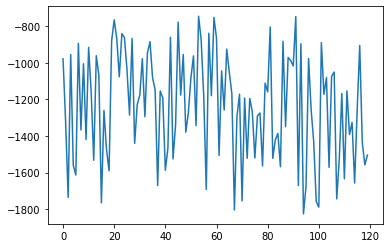

In [24]:
plt.plot(y, x)#u=200